# 준비사항
1. 드라이브 마운트
2. 패키지 설치

In [ ]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 패키지 설치
!pip install kiwipiepy #형태소분석기
!pip install tomotopy #LDA 설계용
import pandas as pd #xlsx파일 불러오기 위한 pandas
import numpy as np
import datetime as dt #날짜 자료형 패키지
import matplotlib.pyplot as plt
import seaborn as sns
import re #정규표현식
import random #랜덤함수
import tomotopy as tp #tomotopy
import collections #counter 호출용
from math import sqrt #제곱근 계산
from tqdm import tqdm
tqdm.pandas() #진행상황 확인
from kiwipiepy import Kiwi, Option #키위
from matplotlib import font_manager, rc #시각화 폰트 패키지
from wordcloud import WordCloud,STOPWORDS #워드클라우드 패키지
from PIL import Image #이미지 배경 패키지

     |████████████████████████████████| 850 kB 5.4 MB/s 
     |████████████████████████████████| 26.5 MB 1.7 MB/s 
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.11.0-py3-none-any.whl size=26552558 sha256=b2bc073d52f531cdb3b673fe9884b47a7fce692381968cf97a753138f98f4bb5
  Stored in directory: /root/.cache/pip/wheels/99/c9/8d/87f32d82825c0739691bc02c7e3a1c6d79dbc9455f955311d4
Successfully built kiwipiepy-model
     |████████████████████████████████| 16.3 MB 324 kB/s 


In [ ]:
#news_all.to_excel('/content/drive/MyDrive/dscvr_g3_preproc.xlsx',encoding='CP949') #전처리 후 중간 저장
news_all=pd.read_excel('/content/drive/MyDrive/dscvr_g3/dscvr_g3_preproc_2.xlsx',index_col=0) #저장된 파일 불러오기

In [ ]:
#파일 확인
news_all.head()

,id,date,press,maintext,date1,year-month
0,1.100401e+06,20170509,동아일보,"석탄발전 퇴출과 원전 축소, 재생에너지 확대는 대선 후보 대부분의 에너지 정책 기조...",2017-05-09,2017-05
1,1.101101e+06,20170508,한국일보,"도널드 트럼프 미국 행정부 요청으로 중국이 대북 압박을 강화하는 것으로 알려졌지만,...",2017-05-08,2017-05
2,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“저 문재인에게 당면한 나라의 위기를 극복할 힘을 주십시오. ...,2017-05-08,2017-05
3,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“많은 분들이 유승민 참 좋은데 찍으면 사표 될까봐 걱정하십니...,2017-05-08,2017-05
4,1.101001e+06,20170508,한겨레,주요 5개 정당 대선 후보들이 대통령에 당선되면 지방분권에 관심을 갖고 헌법 개정 ...,2017-05-08,2017-05


In [ ]:
news_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31262 entries, 0 to 31261
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          31262 non-null  float64       
 1   date        31262 non-null  int64         
 2   press       31262 non-null  object        
 3   maintext    31262 non-null  object        
 4   date1       31262 non-null  datetime64[ns]
 5   year-month  31262 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.7+ MB


#2-2. 기사 토픽모델링
```
셀 실행 순서
1. 분석 준비
2. 명사 추출 함수 정의
3. 명사 추출
4. 정규화 및 커스텀 딕셔너리 작업
5. 다시 명사 추출
6. 불용어 처리
```


##형태소분석

###분석 준비

In [ ]:
#형태소분석기 호출★
kiwi = Kiwi()

In [ ]:
#특수기호 제거
pattern1 = '[-=+,#/\?:;^$.A*"~%!\\\n\r\t<>[]{}()▼▽♣♧§☆♡´∀｀ﾉ♥♡▲△�ㅁ▼▽▶▷◀◁★☆♠♤●○◎⊙◆◇■□＊━▣“”]' #특수기호 목록
news_all['maintext']=news_all['maintext'].progress_map(lambda x:re.sub(pattern1, ' ', x).strip())  # 특수 기호를 " " 공란으로

100%|██████████| 31262/31262 [00:00<00:00, 184216.72it/s]


###명사 추출
kiwi형태소분석은 다음과 같은 형태로 분석이 이루어집니다.

In [ ]:
kiwi.analyze('금잔디에 가면 볶음우동을 먹을 수 있어요')

[([Token(form='금잔디', tag='NNP', start=0, len=3),
   Token(form='에', tag='JKB', start=3, len=1),
   Token(form='가', tag='VV', start=5, len=1),
   Token(form='면', tag='EC', start=6, len=1),
   Token(form='볶음', tag='NNG', start=8, len=2),
   Token(form='우동', tag='NNG', start=10, len=2),
   Token(form='을', tag='JKO', start=12, len=1),
   Token(form='먹', tag='VV', start=14, len=1),
   Token(form='을', tag='ETM', start=15, len=1),
   Token(form='수', tag='NNB', start=17, len=1),
   Token(form='있', tag='VA', start=19, len=1),
   Token(form='어요', tag='EF', start=20, len=2)],
  -69.1999282836914)]

kiwi는 명사 추출 기능이 존재하지 않기 때문에 사용자함수를 정의해 주었습니다. 명사와 고유명사를 추출합니다.

In [ ]:
 #명사 추출 함수 (kiwi 0.10.0)
 def get_noun(texts):
    res = kiwi.analyze(texts)[0][0]
    return [Token[0]
            for Token in res
            if Token[1]=='NNG' or Token[1]=='NNP']

#함수 동작 체크
get_noun('금잔디에 가면 볶음우동을 먹을 수 있어요')

['금잔디', '볶음', '우동']

**부가설명**

Kiwi는 `List[Tuple[List[Tuple[형태소, 품사태그, 시작위치, 문자열길이]], 분석 점수]]` 형태로 분석 결과를 출력합니다.

맨 바깥 리스트에서 res라는 변수를 생성하고(Line 2), 이를 활용하여 품사 태그가 NNG(명사) 혹은 NNP(고유명사)인 형태소만을
리스트 형태로 반환합니다(Line 3~5).

참고로 Kiwi의 품사 태그는 Sejong의 것과 동일합니다.

In [ ]:
# 최초 형태소 분석★
# 전처리 후 다시 형태소분석을 진행할 때도 이 셀을 실행해주세요.
news_all['nouns'] = news_all['maintext'].progress_map(lambda x:get_noun(x))

100%|██████████| 31262/31262 [03:35<00:00, 145.13it/s]


In [ ]:
#결과 확인
news_all.head()

,id,date,press,maintext,date1,year-month,nouns
0,1.100401e+06,20170509,동아일보,"석탄발전 퇴출과 원자력발전소 축소, 재생에너지 확대는 대선 후보 대부분의 에너지 정...",2017-05-09,2017-05,"[석탄, 발전, 퇴출, 원자력발전소, 축소, 재생에너지, 확대, 대선, 후보, 대부..."
1,1.101101e+06,20170508,한국일보,"도널드 트럼프 미국 행정부 요청으로 중국이 대북 압박을 강화하는 것으로 알려졌지만,...",2017-05-08,2017-05,"[도널드, 트럼프, 미국, 행정부, 요청, 중국, 대북, 압박, 강화, 중국, 국영..."
2,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“저 문재인에게 당면한 나라의 위기를 극복할 힘을 주십시오. ...,2017-05-08,2017-05,"[마지막, 한마디, 문재인, 당면, 나라, 위기, 극복, 힘, 개혁, 통합, 흐름,..."
3,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“많은 분들이 유승민 참 좋은데 찍으면 사표 될까봐 걱정하십니...,2017-05-08,2017-05,"[마지막, 한마디, 유승민, 사표, 걱정, 소신, 양심, 후보, 표, 사표, 소신,..."
4,1.101001e+06,20170508,한겨레,주요 5개 정당 대선 후보들이 대통령에 당선되면 지방분권에 관심을 갖고 헌법 개정 ...,2017-05-08,2017-05,"[주요, 정당, 대선, 후보, 대통령, 당선, 지방, 분권, 관심, 헌법, 개정, ..."


In [ ]:
news_all['nouns']

0        [석탄, 발전, 퇴출, 원전, 축소, 재생, 에너지, 확대, 대선, 후보, 대부분,...
1        [도널드, 트럼프, 미국, 행정부, 요청, 중국, 대북, 압박, 강화, 중국, 국영...
2        [마지막, 한마디, 문재인, 당면, 나라, 위기, 극복, 힘, 개혁, 통합, 흐름,...
3        [마지막, 한마디, 유승민, 사표, 걱정, 소신, 양심, 후보, 표, 사표, 소신,...
4        [주요, 정당, 대선, 후보, 대통령, 당선, 지방, 분권, 관심, 헌법, 개정, ...
                               ...                        
31257    [한국전력, 본사, 커뮤니케이션, 실, 언론, 홍보, 팀장, 허태헌, 감사실, 일상...
31258    [방사선, 물질, 원전, 피폭, 발암, 유전자, 변형, 부정, 이미지, 유익, 사용...
31259    [정책, 탈, 정책, 부작용, 정책, 이해관계자, 사이, 이익, 충돌, 점, 대선,...
31260    [울산, 유치, 타당성, 최종, 보고회, 원전, 해체, 기술, 워크숍, 지용기, 박...
31261    [항간, 문재인, 청구서, 말, 최저, 임금, 파동, 다음, 건강, 보험료, 전기,...
Name: nouns, Length: 31262, dtype: object

## 텍스트 전처리 반복
다음 과정을 **아주 많이** 반복합니다:

1. 일부 아이템을 랜덤하게 추출하여 확인

2. 정규화

3. 커스텀 사전 추가

4. 불용어 제거

5. 다시 형태소분석

**기사 랜덤추출**

In [ ]:
#카운터 리셋
counter=0

In [ ]:
i = random.randint(0, 13484) #랜덤 아티클 인덱스_진주
#i = random.randint(13484, 26968)) #랜덤 아티클 인덱스_이훈
#i = random.randint(26968, len(news_all)) #랜덤 아티클 인덱스_석호
print("article {}".format(i)) #인덱스 번호
print(news_all.iloc[i][['maintext','nouns']].values[0]) #기사 본문
print(news_all.iloc[i][['maintext','nouns']].values[1]) #생성된 토큰
counter+=1
print('counter:{}'.format(counter))

**커스텀 사전 추가**
* 고유명사나 신조어, 한 단어로 묶여야 할 단어를 명사로 추가 지정하여 올바르게 명사로 분류될 수 있도록 해 줘야 함
* 그 외 형태소분석이 이상하게 되는 단어도 수동으로 지정해 주면 좋음

In [ ]:
#커스텀 사전★
word_list=['가능성','가상발전소','가스공사','가쓰노부','가짜뉴스','가처분','간나오토','간사','간사이전력','감사보고서','감사위원회','감천항','감포관광단지','갑상선암','강원개발공사','강정민',\
           '개인정보범죄합동수사단','갱도굴착기','검사징계위원회','검찰총장','게이츠노츠','경범죄처벌법,' '경제산업위원회','경제성','경제수석','경주환경운동연합','경진대회','계속운전',\
           '계획예산관실','계획예산총괄담당관','고공행진','고리','고리원자력본부','고리원전','고위공직자범죄수사처','고인곤','고전역주사업','고준위','고준위방사성폐기물','공극','공급사','공동성명',\
           '공동입장문','공상과학','공시가격','공직자윤리법','과거사정리위원회','과기계','과학기술정보방송통신위원회','과학기술정보통신부','관리부문장','광역자치단체','광인전략','구로다고키','구윤철',\
           '구입전력비','국가기후환경회의','국가보안위원회','국가수반','국가에너지기본계획','국가에너지위원회','국무조정실장','국무회의','국민의당','국민의힘','국민인식조사','국방정책실','국사편찬위원장',\
           '국정감사','국제외교안보팀','국제원자력위원회','국제정책대학원','국토교통부','국토안전관리원','국회의원','규제혁파로드맵','기술협력국장','기자회견','기타무라시게루','기획재정부','기획조정실'\
           '김강립','김관진','김균섭','김기춘','김병구','김신숙','김오수','김욱준','김종신','김회평','나그라','나노구조','나병훈','나아일반산업단지','나자르바예프','남북정상회담','노익상','노정환',\
           '다나카순이치','다쓰노긴고','다카하마','다핵종제거설비','단피몽두','당미디어언론상생TF','당상','당정협의','당진에코','대검찰청','대북정책특별대표','대표이사','더불어시민당','던바',\
           '도엘원전','도카이원전','도쿄올림픽','도쿄하계올림픽','동북아평화협력구상','동일본대지진','디젤발전기','로빈던바','리빌딩','릴레이올림픽','마이삭','메종글래드','모두발언',\
           '모하메드빈다이드알나흐얀','무소속','물관리위','미래먹거리','미래통합당','미세먼지','미세먼지','미학원전시리즈','민관합동','민정수석','바이오','박동일','박준수', '관리후생과장','반히데유키',\
           '반역죄','반핵','반핵부산시민대책위원회','방사선보건연구원','방사선보건원','방사성','방사성폐기물','방폐물','방폐장민간환경감시기구','방화댐퍼','백지화','법무부','법무실장','법제사법위원회',\
           '베이징동계올림픽','보건복지부','보궐선거','복심','부산반핵영화제','북한이탈주민정착지원사무소','북한인권기록센터','불구속','불합리','비상대책위원장','비세그라드','비수도권','빌게이츠','빙판길',\
           '사법농단','사법연수원','사쓰마센다이','사용후핵연료관리정책재검토위원회','사용후핵연료','사용후핵연료공론화위원회','사위지기자사','산업발전포럼','산업부',\
           '산업통상자원부','산업통상자원위원회','산업통상자원중소벤처기업위원회','삼덕회계법인','삼척화력','새누리당','샌드박스','서울시장','서한교','석유화학','석유화학산업단지','석좌교수','석탄발전소',\
           '석탄화력발전소','선거대책위원회','성김','성명문','성접대','세계원전사업자협회','세슘나노흡착제','세월호','센다이원전','셀프디스','셰이크칼리파','소득주도성장론','손해배상','송전선로',\
           '숀패트릭','수도권','수소시범도시','수소차','슬라보이지제크','시민위원회','시정역량','시진핑','시험성적서','식품의약품안전처','신고리','신고리원전','신문방송학과','신산업','신월성','신월성원전',\
           '신재생에너지','신치초','신한울','신한울원전','싱크홀','쓰카모토야스시','아베','안전성','알펜시아','압수수색','액화천연가스','야마기시아키히호','양산체계','양해각서','엄재식',\
           '에너지분권','에너지프로슈머','에너지기본계획','에너지자원실장','에너지전환','엘리자베스2세','여야정상설협의체','연료비연동제','열수력','염규진','영구처분시설','영업손실','영업외비용',\
           '영업이익','예비율','예산결산특별위원회','오나가와','오노마사유키','오염수','오이','오이원전','오체투지','왕이','외교통상부','요시아키','운영변경안','운영변경허가안','원내대표','원자력규제위원회',\
           '원자력발전소','원자력방재담','원자력시설해체기술종합연구센터','원자력안전위원','원자력안전위원장','원자력안전위원회','원자력양자공학과','원자력진흥법','원자력진흥위원회',\
           '원자력해체기술종합연구센터','원전게이트','원전반대그룹','원전산업정책과','원전산업정책과장','원전해체청','원전현장','월성1호기','월성원자력본부','월성원전','웨이보','위파','유동준',\
           '유지인트','유튜버','윤석헌','윤종진','윤핵관','이계황','이바라키현','이와시','이완구','이완근','이용률','이은철','이장섭','이적행위','이정택','이청구','이케다가쓰히코','인공태양',\
           '인도적지원','인력양성원','인플루언서','일본경제침략대책특별위원회','임명방','자동차산업발전포럼','자동차산업연합회','자원산업정책관','자유무역협정','자유한국당','자유한국당', '자존가',\
           '장기정비계약','재난지원금','재생에너지','재정개혁보고서','재정개혁특별위원회','저유가','전기사업법','전기요금','전기요금체계','전기차','전남도해양수산과학원','전달력','전력계통','전력구입비',\
           '전력산업기반기금','전력수급기본계획','전력시장담당','전력자원관리실','전력정채관실','전력정책과장','전원개발사업추진위원회','정무수석','정병선','정분희','정상사고','정상회담','정재훈',\
           '정책기획위원회','정책조정수석','정치군인','제염','제이에스','제주특별자치도지사','젠틸리','조기폐쇄','조만대장경','조사과장','조석','주거침입','주기기','주낙영','주영준','주한규',\
           '중국철도건설공사','중대재해','중유','즉시해체','증핵','지구온난화','지방자치단체','지방자치박람회','지소미아','집단면역','징계위원회','쯔엉떤상','찰페로','채희봉','처리수','천지원전',\
           '총괄분과위원회','최고위원','최고위원회의','친문','친환경차','카쿠슈인대','코엔바이오','타당성','탄소중립','탄핵소추안','탈석탄','탈원전','탈핵법률가모임','부롱','투표지분류기',\
           '트레이딩이코노믹스','특별공제','티한지','파이브아이즈','팔래스','패스트트랙','평가조작','평창동계올림픽','품질분임조','하기비스','하라다요시아키','하이선','한국리서치','한국전력',\
           '한국산업연합포럼','한국원자력산업회의','한국원전수출산업협회','한국태양광산업협회','한빛','한빛원자력본부','한빛원전','한울','한울원자력본부','한울원전','한전공대','합동작전',\
           '해상풍력단지','해양방류','해체기술연구부','해체기술원','핵발전소','핵안보정상회의','핵확산금지조약','행정구역','허일후','혁신원자력연구단지','형사법','형사부장','홍남기',\
           '환경방사선','황교안','회담지원과장','후생노동성','후쿠시마제1원전','후타바마치']

In [ ]:
#커스텀 사전 리스트를 dataframe형태로 변환
custom_dict = pd.DataFrame({"word":word_list})

#품사태그는 고유명사로 지정
custom_dict['morp']="NNP"

#Kiwi는 우선순위를 부여하기 위해 score개념이 존재합니다. 커스텀 단어를 우선 활용하기 위해 score값에 1을 부여.
custom_dict['score']=1

#데이터 확인
custom_dict.head()

,word,morp,score
0,가능성,NNP,1
1,가상발전소,NNP,1
2,가스공사,NNP,1
3,가쓰노부,NNP,1
4,가짜뉴스,NNP,1


In [ ]:
#커스텀 사전을 csv로 저장하고 불러옴★
custom_dict.to_csv("/content/drive/MyDrive/dscvr_g3/custom_dict.txt", index=False, header=False, sep="\t",encoding='UTF-8')

#kiwi의 load_user_dictionary는 커스텀 사전을 변경할 경우 업데이트된 단어의 수를 반환해 줍니다.
kiwi.load_user_dictionary('/content/drive/MyDrive/dscvr_g3/custom_dict.txt')

**단어 정규화**
* 정규화: 동일한 표현을 다르게 쓴 것을 모두 통일해주는 것

영어 약자, 유행병 이름, 사람 이름, 한자 및 영어 표현 등 수작업으로 교체하여 분류 정확도 높이기

In [ ]:
#임시 셀
#text_to_replace='‘123협정’:‘한미 원자력협정’,‘감사위’:’감사위원회’,‘고리’:’고리원전,‘고검’:’고등검찰’‘고법’:’고등법원’,‘공수처’:’고위공직자범죄수사처’,‘과기정통부’:’과학기술정보통신부’,‘과방위’:’과학기술정보방송통신위원회’,‘국토부’:’국토교통부,‘국편’:’국사편찬위원회’,‘국힘’:’국민의힘’,‘개인정보범죄 정부합동수사단’: ‘개인정보범죄정부합동수사단’,‘기재부’:’기획재정부’,‘대검’:’대검찰청’,‘대법’:’대법원’,‘대사’:’외교관’,‘도카이제2원전’:‘도카이원전’,‘리스크’:’위험 요인’,‘모럴 해저드’:‘도덕적 해이’,‘방폐물’:‘방사성폐기물’, ‘방사성 폐기물’:‘방사성폐기물’, ‘박 대통령’:‘박근혜 대통령’,‘산업부’:’산업통상자원부’,‘시민당’:’더불어시민당’,‘시 주석’:‘시진핑 국가주석’, ‘사용후 핵연료’:‘사용후핵연료’,‘산업자원통상부’: ‘산업통상자원부’,‘식약처’:’식품의약품안전처’‘신고리’:‘신고리원전’, ‘신한울’:‘신한울원전’,‘여수산단’:’여수국가산업단지’,‘영구저장시설’: ‘영구처분시설’,‘산업부’:‘산업통상자원부’,‘산자위’:’산업통상자원중소벤처기업위원회’,‘안전처’: ‘국민안전처’,‘영덕 원전’:‘천지원전’, ‘영덕 원전’:‘영덕 천지원전’, ‘원안위’:‘원자력안전위원회’,‘아베 신조’: ‘아베’, ‘오이’: ‘오이원전’,‘월성본부’:’월성원자력본부’,‘원전’:‘원자력발전소’, ‘원해연’:’원자력해체기술종합연구센터’,‘원자력시설 해체기술 종합연구센터’:’원자력해체기술종합연구센터’,‘공 태양’:‘인공태양’,‘즉시 해체’:’즉시해체’,‘지법’:‘지방법원’, ‘지검’:’지방검찰청’,‘지연 해체’:’지연해체’,‘체르노빌 발전소’: ‘체르노빌 원전’,‘트리튬’:’삼중수소’,‘특위’:’특별위원회’,‘핵발전소’:‘원자력발전소’,‘한수원’:‘한국수력원자력’,  ‘한빛’:‘한빛원전’,‘한울’:‘한울원전’, ‘핵폐기물’:‘방사성폐기물’,‘IAEA’:‘국제원자력기구’,‘NRC’:’원자력규제위원회’,‘UAE’:’아랍에미리트’ ‘韓’:‘한국’,‘與’:’여당’,‘野’:’야당’,‘北’:‘북한’,‘(脫)’:’’,‘(非)’:’’,‘(正常)’:’’'
#text_to_replace.replace("‘","'").replace("’","'")

"'123협정':'한미 원자력협정','감사위':'감사위원회','고리':'고리원전,'고검':'고등검찰''고법':'고등법원','공수처':'고위공직자범죄수사처','과기정통부':'과학기술정보통신부','과방위':'과학기술정보방송통신위원회','국토부':'국토교통부,'국편':'국사편찬위원회','국힘':'국민의힘','개인정보범죄 정부합동수사단': '개인정보범죄정부합동수사단','기재부':'기획재정부','대검':'대검찰청','대법':'대법원','대사':'외교관','도카이제2원전':'도카이원전','리스크':'위험 요인','모럴 해저드':'도덕적 해이','방폐물':'방사성폐기물', '방사성 폐기물':'방사성폐기물', '박 대통령':'박근혜 대통령','산업부':'산업통상자원부','시민당':'더불어시민당','시 주석':'시진핑 국가주석', '사용후 핵연료':'사용후핵연료','산업자원통상부': '산업통상자원부','식약처':'식품의약품안전처''신고리':'신고리원전', '신한울':'신한울원전','여수산단':'여수국가산업단지','영구저장시설': '영구처분시설','산업부':'산업통상자원부','산자위':'산업통상자원중소벤처기업위원회','안전처': '국민안전처','영덕 원전':'천지원전', '영덕 원전':'영덕 천지원전', '원안위':'원자력안전위원회','아베 신조': '아베', '오이': '오이원전','월성본부':'월성원자력본부','원전':'원자력발전소', '원해연':'원자력해체기술종합연구센터','원자력시설 해체기술 종합연구센터':'원자력해체기술종합연구센터','공 태양':'인공태양','즉시 해체':'즉시해체','지법':'지방법원', '지검':'지방검찰청','지연 해체':'지연해체','체르노빌 발전소': '체르노빌 원전','트리튬':'삼중수소','특위':'특별위원회','핵발전소':'원자력발전소','한수원':'한국수력원자력',  '한빛':'한빛원전','한울':'한울원전', '핵폐기물':'방사성폐기물','IAEA':'국제원자력기구','NRC':'원자력규제위원회','UAE':'아랍에미리트' '韓':'한

In [ ]:
#정규화 딕셔너리 ★
dic_standardization={'123협정':'한미 원자력협정','감사위':'감사위원회','고리':'고리원전','고검':'고등검찰','고법':'고등법원','공수처':'고위공직자범죄수사처','과기정통부':'과학기술정보통신부',\
                     '과방위':'과학기술정보방송통신위원회','국토부':'국토교통부','국편':'국사편찬위원회','국힘':'국민의힘','개인정보범죄 정부합동수사단': '개인정보범죄정부합동수사단',\
                     '기재부':'기획재정부','대검':'대검찰청','대법':'대법원','대사':'외교관','도카이제2원전':'도카이원전','리스크':'위험 요인','모럴 해저드':'도덕적 해이','방폐물':'방사성폐기물',\
                     '방사성 폐기물':'방사성폐기물', '박 대통령':'박근혜 대통령','산업부':'산업통상자원부','시민당':'더불어시민당','시 주석':'시진핑 국가주석', '사용후 핵연료':'사용후핵연료',\
                     '산업자원통상부':'산업통상자원부','식약처':'식품의약품안전처','신고리':'신고리원전', '신한울':'신한울원전','여수산단':'여수국가산업단지','영구저장시설': '영구처분시설',\
                     '산업부':'산업통상자원부','산자위':'산업통상자원중소벤처기업위원회','안전처': '국민안전처','영덕 원전':'천지원전', '영덕 원전':'영덕 천지원전','원안위':'원자력안전위원회',\
                     '아베 신조': '아베', '오이': '오이원전','월성본부':'월성원자력본부','원전':'원자력발전소', '원해연':'원자력해체기술종합연구센터',\
                     '원자력시설 해체기술 종합연구센터':'원자력해체기술종합연구센터','인공 태양':'인공태양','즉시 해체':'즉시해체','지법':'지방법원', '지검':'지방검찰청','지연 해체':'지연해체',\
                     '체르노빌 발전소': '체르노빌 원전','트리튬':'삼중수소','특위':'특별위원회','핵발전소':'원자력발전소','한수원':'한국수력원자력',  '한빛':'한빛원전','한울':'한울원전',\
                     '핵폐기물':'방사성폐기물','IAEA':'국제원자력기구','NRC':'원자력규제위원회','UAE':'아랍에미리트','韓':'한국','與':'여당','野':'야당','北':'북한','(脫)':'','(非)':'','(正常)':''}

In [ ]:
#정규화 딕셔너리를 활용하여 단어 교체★
for old, new in dic_standardization.items():
  print("convert {} into {}.".format (old, new))
  news_all['maintext'] = news_all['maintext'].progress_map(lambda x:x.replace(old, new))

convert 123협정 into 한미 원자력협정.


100%|██████████| 31262/31262 [00:00<00:00, 569146.87it/s]


convert 감사위 into 감사위원회.


100%|██████████| 31262/31262 [00:00<00:00, 601238.64it/s]


convert 고리 into 고리원전.


100%|██████████| 31262/31262 [00:00<00:00, 554742.78it/s]


convert 고검 into 고등검찰.


100%|██████████| 31262/31262 [00:00<00:00, 506363.54it/s]


convert 고법 into 고등법원.


100%|██████████| 31262/31262 [00:00<00:00, 528186.63it/s]


convert 공수처 into 고위공직자범죄수사처.


100%|██████████| 31262/31262 [00:00<00:00, 644741.32it/s]


convert 과기정통부 into 과학기술정보통신부.


100%|██████████| 31262/31262 [00:00<00:00, 264642.32it/s]


convert 과방위 into 과학기술정보방송통신위원회.


100%|██████████| 31262/31262 [00:00<00:00, 266145.83it/s]


convert 국토부 into 국토교통부.


100%|██████████| 31262/31262 [00:00<00:00, 254488.86it/s]


convert 국편 into 국사편찬위원회.


100%|██████████| 31262/31262 [00:00<00:00, 222834.58it/s]


convert 국힘 into 국민의힘.


100%|██████████| 31262/31262 [00:00<00:00, 307334.29it/s]


convert 개인정보범죄 정부합동수사단 into 개인정보범죄정부합동수사단.


100%|██████████| 31262/31262 [00:00<00:00, 280037.70it/s]


convert 기재부 into 기획재정부.


100%|██████████| 31262/31262 [00:00<00:00, 260725.16it/s]


convert 대검 into 대검찰청.


100%|██████████| 31262/31262 [00:00<00:00, 636828.40it/s]


convert 대법 into 대법원.


100%|██████████| 31262/31262 [00:00<00:00, 553023.11it/s]


convert 대사 into 외교관.


100%|██████████| 31262/31262 [00:00<00:00, 561215.25it/s]


convert 도카이제2원전 into 도카이원전.


100%|██████████| 31262/31262 [00:00<00:00, 661452.28it/s]


convert 리스크 into 위험 요인.


100%|██████████| 31262/31262 [00:00<00:00, 501117.22it/s]


convert 모럴 해저드 into 도덕적 해이.


100%|██████████| 31262/31262 [00:00<00:00, 609851.45it/s]


convert 방폐물 into 방사성폐기물.


100%|██████████| 31262/31262 [00:00<00:00, 624588.35it/s]


convert 방사성 폐기물 into 방사성폐기물.


100%|██████████| 31262/31262 [00:00<00:00, 568492.96it/s]


convert 박 대통령 into 박근혜 대통령.


100%|██████████| 31262/31262 [00:00<00:00, 546072.29it/s]


convert 산업부 into 산업통상자원부.


100%|██████████| 31262/31262 [00:00<00:00, 598918.07it/s]


convert 시민당 into 더불어시민당.


100%|██████████| 31262/31262 [00:00<00:00, 561332.98it/s]


convert 시 주석 into 시진핑 국가주석.


100%|██████████| 31262/31262 [00:00<00:00, 596588.20it/s]

convert 사용후 핵연료 into 사용후핵연료.

100%|██████████| 31262/31262 [00:00<00:00, 554055.97it/s]


convert 산업자원통상부 into 산업통상자원부.


100%|██████████| 31262/31262 [00:00<00:00, 703189.46it/s]


convert 식약처 into 식품의약품안전처.


100%|██████████| 31262/31262 [00:00<00:00, 700234.07it/s]


convert 신고리 into 신고리원전.


100%|██████████| 31262/31262 [00:00<00:00, 633686.12it/s]


convert 신한울 into 신한울원전.


100%|██████████| 31262/31262 [00:00<00:00, 461895.14it/s]


convert 여수산단 into 여수국가산업단지.


100%|██████████| 31262/31262 [00:00<00:00, 596767.41it/s]


convert 영구저장시설 into 영구처분시설.


100%|██████████| 31262/31262 [00:00<00:00, 626875.68it/s]


convert 산자위 into 산업통상자원중소벤처기업위원회.


100%|██████████| 31262/31262 [00:00<00:00, 547771.82it/s]


convert 안전처 into 국민안전처.


100%|██████████| 31262/31262 [00:00<00:00, 583025.04it/s]


convert 영덕 원전 into 영덕 천지원전.


100%|██████████| 31262/31262 [00:00<00:00, 540416.48it/s]


convert 원안위 into 원자력안전위원회.


100%|██████████| 31262/31262 [00:00<00:00, 590862.04it/s]


convert 아베 신조 into 아베.


100%|██████████| 31262/31262 [00:00<00:00, 542249.07it/s]


convert 오이 into 오이원전.


100%|██████████| 31262/31262 [00:00<00:00, 596647.93it/s]


convert 월성본부 into 월성원자력본부.


100%|██████████| 31262/31262 [00:00<00:00, 678406.10it/s]


convert 원전 into 원자력발전소.


100%|██████████| 31262/31262 [00:00<00:00, 503543.91it/s]


convert 원해연 into 원자력해체기술종합연구센터.


100%|██████████| 31262/31262 [00:00<00:00, 541031.92it/s]


convert 원자력시설 해체기술 종합연구센터 into 원자력해체기술종합연구센터.


100%|██████████| 31262/31262 [00:00<00:00, 699009.67it/s]


convert 인공 태양 into 인공태양.


100%|██████████| 31262/31262 [00:00<00:00, 524394.94it/s]


convert 즉시 해체 into 즉시해체.


100%|██████████| 31262/31262 [00:00<00:00, 406060.86it/s]


convert 지법 into 지방법원.


100%|██████████| 31262/31262 [00:00<00:00, 598488.89it/s]


convert 지검 into 지방검찰청.


100%|██████████| 31262/31262 [00:00<00:00, 637537.47it/s]


convert 지연 해체 into 지연해체.


100%|██████████| 31262/31262 [00:00<00:00, 562544.33it/s]


convert 체르노빌 발전소 into 체르노빌 원전.


100%|██████████| 31262/31262 [00:00<00:00, 639137.88it/s]


convert 트리튬 into 삼중수소.


100%|██████████| 31262/31262 [00:00<00:00, 525795.40it/s]


convert 특위 into 특별위원회.


100%|██████████| 31262/31262 [00:00<00:00, 703272.43it/s]


convert 핵발전소 into 원자력발전소.


100%|██████████| 31262/31262 [00:00<00:00, 662752.82it/s]


convert 한수원 into 한국수력원자력.


100%|██████████| 31262/31262 [00:00<00:00, 579441.21it/s]


convert 한빛 into 한빛원전.


100%|██████████| 31262/31262 [00:00<00:00, 612870.10it/s]


convert 한울 into 한울원전.


100%|██████████| 31262/31262 [00:00<00:00, 616637.11it/s]


convert 핵폐기물 into 방사성폐기물.


100%|██████████| 31262/31262 [00:00<00:00, 586976.50it/s]


convert IAEA into 국제원자력기구.


100%|██████████| 31262/31262 [00:00<00:00, 505097.62it/s]


convert NRC into 원자력규제위원회.


100%|██████████| 31262/31262 [00:00<00:00, 619503.87it/s]


convert UAE into 아랍에미리트.


100%|██████████| 31262/31262 [00:00<00:00, 644801.56it/s]


convert 韓 into 한국.


100%|██████████| 31262/31262 [00:00<00:00, 503192.22it/s]


convert 與 into 여당.


100%|██████████| 31262/31262 [00:00<00:00, 594591.69it/s]


convert 野 into 야당.


100%|██████████| 31262/31262 [00:00<00:00, 564221.83it/s]


convert 北 into 북한.


100%|██████████| 31262/31262 [00:00<00:00, 626528.22it/s]


convert (脫) into .


100%|██████████| 31262/31262 [00:00<00:00, 579111.08it/s]


convert (非) into .


100%|██████████| 31262/31262 [00:00<00:00, 627529.70it/s]


convert (正常) into .


100%|██████████| 31262/31262 [00:00<00:00, 638322.69it/s]


**불용어 제거**

불용어는 분석에 사용되지 않을 단어를 의미합니다. 다음 유형의 단어를 제거하였습니다:

1. 자연어처리 시 통용되는 불용어 리스트
2. 너무 많이 등장하는 단어들 - 모든 문서에서 공통적으로 등장하여 분류 성능을 낮출 우려가 있음.
3. 한 단어로 된 단어
4. 토픽 특성상 핵심 주제어인 '원전' '원자력발전'도 제거하는 게 좋음


In [ ]:
#1차 필터링: 한국어 불용어 사전 활용★
stop_list1 = open('/content/drive/MyDrive/dscvr_g3/Korean Stopwords.txt', encoding = 'utf-8')
stop_list2 = open('/content/drive/MyDrive/dscvr_g3/stopwords_ko.txt', encoding = 'utf-8')

lines1 = stop_list1.readlines() #한 줄마다 읽어옴
lines2 = stop_list2.readlines() #한 줄마다 읽어옴

stopwords = [] #불용어 리스트
for line in lines1:
    a= line.split() #줄 단위 분할
    stopwords.append(a) #한 줄마다 불용어 리스트에 추가
for line in lines2:
    b= line.split() #줄 단위 분할
    stopwords.append(b) #한 줄마다 불용어 리스트에 추가
  

In [ ]:
#2차 필터링: 커스텀 불용어 리스트★
custom_stopwords = ['원전','원자력','발전소','원자력발전소','관련','한국','전력','이날','발생','이후','이번','오후','오전','가운데','기자','사진','최근','정부','일본','한국수력원자력']
stopwords+=custom_stopwords #커스텀 불용어를 리스트에 추가

In [ ]:
#'불용어 리스트에 없는'형태소만 남기는 방식으로 불용어 제거★
news_all['nouns'] = news_all['nouns'].progress_map(lambda x:[w for w in x if w not in stopwords])

100%|██████████| 31262/31262 [00:30<00:00, 1032.01it/s]


In [ ]:
#3차 필터링: 한 글자 제거★
news_all['nouns'] = news_all['nouns'].progress_map(lambda x:[w for w in x if len(w) > 1])

100%|██████████| 31262/31262 [00:00<00:00, 84006.36it/s]


In [ ]:
news_all.head()

,id,date,press,maintext,date1,year-month,nouns
0,1.100401e+06,20170509,동아일보,"석탄발전 퇴출과 원자력발전소 축소, 재생에너지 확대는 대선 후보 대부분의 에너지 정...",2017-05-09,2017-05,"[석탄, 발전, 퇴출, 축소, 재생에너지, 확대, 대선, 후보, 대부분, 에너지, ..."
1,1.101101e+06,20170508,한국일보,"도널드 트럼프 미국 행정부 요청으로 중국이 대북 압박을 강화하는 것으로 알려졌지만,...",2017-05-08,2017-05,"[도널드, 트럼프, 미국, 행정부, 요청, 중국, 대북, 압박, 강화, 중국, 국영..."
2,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“저 문재인에게 당면한 나라의 위기를 극복할 힘을 주십시오. ...,2017-05-08,2017-05,"[마지막, 한마디, 문재인, 당면, 나라, 위기, 극복, 개혁, 통합, 흐름, 대한..."
3,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“많은 분들이 유승민 참 좋은데 찍으면 사표 될까봐 걱정하십니...,2017-05-08,2017-05,"[마지막, 한마디, 유승민, 사표, 걱정, 소신, 양심, 후보, 사표, 소신, 투표..."
4,1.101001e+06,20170508,한겨레,주요 5개 정당 대선 후보들이 대통령에 당선되면 지방분권에 관심을 갖고 헌법 개정 ...,2017-05-08,2017-05,"[주요, 정당, 대선, 후보, 대통령, 당선, 지방, 분권, 관심, 헌법, 개정, ..."


불용어 처리를 마쳤으면, 빈도 수 파악 후 2차 필터링할 단어 리스트를 수정하기 위해, 단어 개수를 카운트합니다.

In [ ]:
#단어 빈도 파악
nouncounter=news_all['nouns'].sum() #형태소 목록 병합
counts = collections.Counter(nouncounter) #병합된 목록 카운트
print(counts) #결과

카운트 결과는 여기서 보는 것보다 복사해서 메모장이나 워드로 보는게 편해요!

## 토픽모델링

먼저 LDA 모델을 생성합니다.

In [ ]:
# LDA Model 정의★
def lda(k_model, iteration, text, word_remove=0):
    
    # 모델 설정
    model = tp.LDAModel(k=k_model, rm_top=word_remove, seed=29672)
    
    # 문서 추가 
    for n, line in enumerate(text):
        line = ','.join(line)
        model.add_doc(line.strip().split(','))
    
    model.burn_in = 100
    model.train(0)
    
    print('문서 개수:', len(model.docs), ', 단어 개수:', len(model.used_vocabs), ', 단어의 총수:', model.num_words, '토픽 수:',k_model)
    #print('제거된 단어들:', model.removed_top_words)
    
    print('훈련 중',flush=True)
    for i in range(0, iteration, 50):
        model.train(10)
    
    model.summary()
    return(model)

여러 번 반복을 통해 최적의 K값을 찾습니다. 먼저 K값 후보 리스트를 생성합니다.

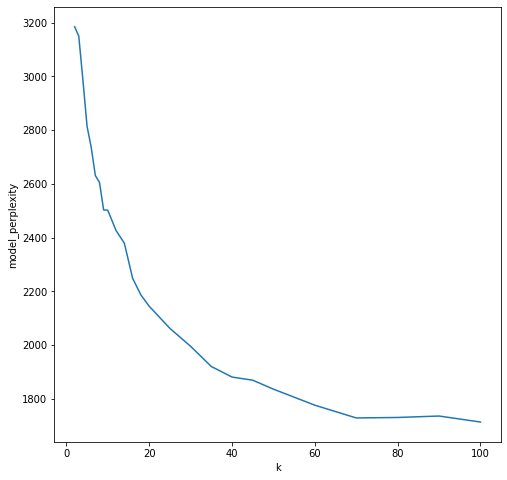

In [ ]:
#Perplexity 값 시각화
fig, ((ax1))= plt.subplots(nrows=1, ncols=1)   #(1,1)짜리 subplot
fig.set_size_inches(8,8)  #사이즈 지정
sns.lineplot(x="k", y="model_perplexity", data=perplexity_df, ax=ax1) #k값과 perplexity를 x, y로 하는 선 그래프

K값 정한 후 최적의 모델을 출력합니다.
Perplexity값이 충분히 낮아야 분류 결과의 신뢰가 있지만, K값이 너무 커지면 지나치게 상세하게 분류가 이루어지기 때문에, 적당한 수준에서 K값을 선정하였습니다.

In [ ]:
  #최적화된 모델 출력
  k = 30
  mdl_k=lda(k, 1000, text=news_all['nouns']) #모델링

문서 개수: 31262 , 단어 개수: 30221 , 단어의 총수: 953858 토픽 수: 30
훈련 중
<Basic Info>
| LDAModel (current version: 0.12.2)
| 31262 docs, 953858 words
| Total Vocabs: 30221, Used Vocabs: 30221
| Entropy of words: 8.05734
| Entropy of term-weighted words: 8.05734
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 200, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -7.68314
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 30 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 29672 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet p

가장 높은 확률에 해당하는 토픽으로 각 문서를 분류합니다.

In [ ]:
#개별 주제에 속할 확률을 제시하는 데이터프레임
new_df = pd.DataFrame()
for i, line in enumerate(mdl_k.docs):
    temp=pd.DataFrame(line.get_topic_dist()).T
    new_df=new_df.append(temp)
new_df = new_df.reset_index()
new_df = new_df.drop(['index'], axis=1)
new_df.columns = ['#'+ str(x) for x in range(1,k+1)]

In [ ]:
new_df.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#21,#22,#23,#24,#25,#26,#27,#28,#29,#30
0,0.001394,0.000918,0.612153,0.000964,0.000947,0.002021,0.111579,0.000753,0.000939,0.000568,...,0.000297,0.000817,0.000534,0.000738,0.000936,0.001101,0.001009,0.001053,0.001380,0.001150
1,0.001255,0.000826,0.001602,0.475352,0.000852,0.001819,0.000542,0.000678,0.400411,0.100402,...,0.000267,0.000735,0.000481,0.000664,0.000842,0.000991,0.000908,0.000948,0.001242,0.001035
2,0.001858,0.001223,0.002372,0.001285,0.001262,0.668288,0.000802,0.259846,0.001252,0.000756,...,0.000396,0.001089,0.000712,0.000984,0.038225,0.001468,0.001344,0.001404,0.001839,0.001533
3,0.319833,0.001500,0.002911,0.001576,0.001548,0.366224,0.000984,0.001232,0.001536,0.000928,...,0.000485,0.001335,0.000874,0.001207,0.001530,0.001801,0.001649,0.001722,0.002256,0.001880
4,0.001167,0.000768,0.001491,0.093736,0.000793,0.048157,0.070201,0.000631,0.000787,0.000475,...,0.000249,0.000684,0.000447,0.000618,0.000784,0.000922,0.000845,0.000882,0.001155,0.000963


In [ ]:
#idxmax 활용하여 가장 가능성 높은 확률의 토픽을 기존 데이터 끝에 붙임
theta_df = news_all.merge(new_df, left_index=True, right_index=True)
theta_df['topic']=theta_df[['#'+ str(s) for s in range(1, k+1)]].idxmax(axis=1)
theta_df.head()

,id,date,press,maintext,date1,year-month,nouns,#1,#2,#3,...,#22,#23,#24,#25,#26,#27,#28,#29,#30,topic
0,1.100401e+06,20170509,동아일보,"석탄발전 퇴출과 원자력발전소 축소, 재생에너지 확대는 대선 후보 대부분의 에너지 정...",2017-05-09,2017-05,"[석탄, 발전, 퇴출, 축소, 재생에너지, 확대, 대선, 후보, 대부분, 에너지, ...",0.001394,0.000918,0.612153,...,0.000817,0.000534,0.000738,0.000936,0.001101,0.001009,0.001053,0.001380,0.001150,#3
1,1.101101e+06,20170508,한국일보,"도널드 트럼프 미국 행정부 요청으로 중국이 대북 압박을 강화하는 것으로 알려졌지만,...",2017-05-08,2017-05,"[도널드, 트럼프, 미국, 행정부, 요청, 중국, 대북, 압박, 강화, 중국, 국영...",0.001255,0.000826,0.001602,...,0.000735,0.000481,0.000664,0.000842,0.000991,0.000908,0.000948,0.001242,0.001035,#4
2,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“저 문재인에게 당면한 나라의 위기를 극복할 힘을 주십시오. ...,2017-05-08,2017-05,"[마지막, 한마디, 문재인, 당면, 나라, 위기, 극복, 개혁, 통합, 흐름, 대한...",0.001858,0.001223,0.002372,...,0.001089,0.000712,0.000984,0.038225,0.001468,0.001344,0.001404,0.001839,0.001533,#6
3,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“많은 분들이 유승민 참 좋은데 찍으면 사표 될까봐 걱정하십니...,2017-05-08,2017-05,"[마지막, 한마디, 유승민, 사표, 걱정, 소신, 양심, 후보, 사표, 소신, 투표...",0.319833,0.001500,0.002911,...,0.001335,0.000874,0.001207,0.001530,0.001801,0.001649,0.001722,0.002256,0.001880,#6
4,1.101001e+06,20170508,한겨레,주요 5개 정당 대선 후보들이 대통령에 당선되면 지방분권에 관심을 갖고 헌법 개정 ...,2017-05-08,2017-05,"[주요, 정당, 대선, 후보, 대통령, 당선, 지방, 분권, 관심, 헌법, 개정, ...",0.001167,0.000768,0.001491,...,0.000684,0.000447,0.000618,0.000784,0.000922,0.000845,0.000882,0.001155,0.000963,#12


In [ ]:
#토픽별로 최빈 단어 파악하기 위한 데이터프레임
topic_df = pd.DataFrame()
for i in range(0, k):
  temp = pd.DataFrame()
  temp = pd.DataFrame(mdl_k.get_topic_words(i, top_n=10))
  temp.columns = ["#"+str(i+1),"probs"+str(i+1)]
  temp = temp.reset_index()
  if (i==0):
      topic_df = topic_df.append(temp, ignore_index=True)
  else:
      topic_df = topic_df.merge(temp, left_on="index", right_on="index")

최종 토픽 확인

In [ ]:
#토픽 확인하기
for i in range(1,31):
  cnt = len(theta_df[theta_df['topic']=='#'+str(i)])
  print("토픽 {:8}: 토픽 개수 {:8}, 전체 퍼센트 {:8.3f}%".format(i, cnt, cnt/len(news_all)*100)) # 해당 토픽의 정보 
  print(topic_df['#'+str(i)]) # 해당 토픽에서 가장 많이 나오는 단어 
  print(theta_df[theta_df['topic']=='#'+str(i)]['maintext'].sample(n=20).values) # 임의로 선택 20(n)개의 문서 
  print("\n\n==================================================================================\n\n")

토픽        1: 토픽 개수     1103, 전체 퍼센트    3.528%
0     대통령
1     문재인
2     청와대
3      정책
4    감사원장
5     박근혜
6     최재형
7      정치
8      원장
9      감사
Name: #1, dtype: object
['<!-- SUB_TITLE_START-->ㆍ“MB 뜻” 취임 뒤 무리한 M&A 철강 불황 겹쳐 ‘추락’ㆍ“천신일 박영준이 민다” 의혹 속 이구택 전격 퇴진시키고 취임<strong style..'
 '윤석열 검찰총장이 4일 사임했습니다. 7월 임기 만료를 4개월 앞두고 전격적으로 사퇴한 겁니다. 그의 사퇴문은 날선 표현들로 가득했습니다. “헌법정신과 법치시스템이 파괴되고 있다. 그 피해는 고스란히 국민에게 돌아갈 것”이라며 자신이 몸 담았던 문재인 정부와 여권을 맹비난했습니다. 요 며칠 언론 인터뷰 등을 통해 여권의 ‘중대범죄수사청’ 추진에 대해 “..'
 '문재인 대통령이 탈원자력발전소을 선언한 직후 산업통상자원부가 신규 원자력발전소 계획을 백지화하는 수순에 들어간 것으로 알려지자 경북 영덕군이 술렁이고 있다. 경북 울진군과 경주시는 기존 원자력발전소시설이 들어선 곳이라 충격이 덜하지만, 영덕은 원자력발전소유치를 둘러싸고 찬반논란으로 홍역을 치른 곳이다. \n \n영덕군 관계자는 21일 "일단 6월말 확정될 정부의 100대 국정기획과제와..'
 '문재인 대통령이 3일 내각과 청와대 수석급 이상 참모진의 인선을 마무리했다. 문 대통령은 이날 산업통상자원부 장관에 백운규(53) 한양대 제3공과대학 학장을, 보건복지부 장관에 박능후(61) 경기대 사회복지학과 교수를 각각 지명했다. 장관급으로 국회 인사청문회에 거쳐야하는 방송통신위원장에는 이효성(66) 전 방송위원회 부위원장이, 금융위원장에는 최종구(..'
 '야당의 비토권(거부권)을 무력화하는 고위공직자범죄수사처(고위공직자범죄수사처)법 개정안이 10일 야당 반대 속에 국회 본회의를 통과했다. 문재인 대통령이 지난

In [ ]:
theta_df.head()

,id,date,press,maintext,date1,year-month,nouns,#1,#2,#3,...,#22,#23,#24,#25,#26,#27,#28,#29,#30,topic
0,1.100401e+06,20170509,동아일보,"석탄발전 퇴출과 원자력발전소 축소, 재생에너지 확대는 대선 후보 대부분의 에너지 정...",2017-05-09,2017-05,"['석탄', '발전', '퇴출', '원자력발전소', '축소', '재생에너지', '확...",0.077733,0.000697,0.000591,...,0.000637,0.000479,0.000586,0.001296,0.000665,0.000615,0.000663,0.077580,0.001293,#8
1,1.101101e+06,20170508,한국일보,"도널드 트럼프 미국 행정부 요청으로 중국이 대북 압박을 강화하는 것으로 알려졌지만,...",2017-05-08,2017-05,"['도널드', '트럼프', '미국', '행정부', '요청', '중국', '대북', ...",0.000991,0.000647,0.000549,...,0.000591,0.000445,0.000544,0.001204,0.000617,0.000571,0.000616,0.000849,0.001200,#16
2,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“저 문재인에게 당면한 나라의 위기를 극복할 힘을 주십시오. ...,2017-05-08,2017-05,"['마지막', '한마디', '문재인', '당면', '나라', '위기', '극복', ...",0.001385,0.000905,0.000768,...,0.000827,0.000622,0.000761,0.001683,0.000863,0.000799,0.199993,0.001187,0.001679,#19
3,1.100101e+06,20170508,경향신문,■마지막 한마디\n\n“많은 분들이 유승민 참 좋은데 찍으면 사표 될까봐 걱정하십니...,2017-05-08,2017-05,"['마지막', '한마디', '유승민', '사표', '걱정', '소신', '양심', ...",0.537364,0.039313,0.000885,...,0.000954,0.000717,0.000878,0.001941,0.000995,0.000921,0.000993,0.001369,0.001936,#1
4,1.101001e+06,20170508,한겨레,주요 5개 정당 대선 후보들이 대통령에 당선되면 지방분권에 관심을 갖고 헌법 개정 ...,2017-05-08,2017-05,"['주요', '정당', '대선', '후보', '대통령', '당선', '지방', '분...",0.544784,0.000618,0.000524,...,0.000565,0.000425,0.000520,0.001149,0.000589,0.000545,0.000588,0.000810,0.001146,#1


## 분석을 위한 데이터프레임 가공

In [ ]:
#데이터프레임 피봇
groupby_topic=theta_df[['id','press','topic']].groupby(['press','topic']).agg('count')
group_pivot=groupby_topic.pivot_table(index='press',columns='topic')
group_pivot=group_pivot['id']

In [ ]:
#토픽 번호 데이터프레임 생성
df=[]
for i in range(1,31):
  df.append('#'+str(i))
group_pivot=group_pivot[df]

In [ ]:
#토픽별 집계
groupby_topic=theta_df[['id','press','topic']].groupby(['press','topic']).agg('count')

In [ ]:
groupby_topic

id
press topic     
경향신문  #1     158
      #10    158
      #11    116
      #12    232
      #13     75
...          ...
한국일보  #5      77
      #6      62
      #7     188
      #8     114
      #9      41

[330 rows x 1 columns]

In [ ]:
group_pivot

topic,#1,#10,#11,#12,#13,#14,#15,#16,#17,#18,...,#28,#29,#3,#30,#4,#5,#6,#7,#8,#9
press,,,,,,,,,,,,,,,,,,,,,
경향신문,158,158,116,232,75,44,208,129,111,110,...,72,108,126,129,218,90,71,353,180,45
국민일보,93,167,92,133,72,19,93,120,159,111,...,61,61,84,83,107,92,62,144,106,50
내일신문,38,26,75,16,41,30,32,17,127,32,...,16,50,14,32,42,57,33,49,94,5
동아일보,88,82,69,72,70,58,54,108,151,78,...,80,51,58,107,52,60,31,91,102,53
문화일보,76,60,141,67,44,11,31,109,145,39,...,85,62,48,43,114,120,62,102,235,33
서울신문,85,191,82,139,71,37,59,112,95,87,...,84,100,67,93,88,89,36,132,79,46
세계일보,190,250,218,281,94,37,93,167,175,227,...,135,75,133,96,137,100,74,337,147,81
조선일보,140,69,213,50,84,15,42,145,209,128,...,114,101,33,87,63,158,34,133,365,90
중앙일보,177,140,157,110,73,21,41,137,155,153,...,115,74,82,156,103,92,45,146,175,92


In [ ]:
df=[]
for i in range(1,31):
  df.append('#'+str(i))
group_pivot=group_pivot[df]

In [ ]:
group_pivot.to_csv('/content/drive/MyDrive/dscvr_g3/dscvr_g3_pivot_df.xlsx',encoding='CP949') #내보내기